# Fast Gradient Sign Method

## Train Threat Model

In [13]:
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [26]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

device = torch.device('mps' if torch.backends.mps.is_available else 'cpu')
device

device(type='mps')

In [32]:
def train(model, criterion, optimizer, device, num_epochs=10):
    
    model.train()
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(trainset)
        epoch_acc = running_corrects.float() / len(trainset)
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
    return model

In [33]:
model_ft = models.vgg16(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False
model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier.parameters(), lr=0.001, momentum=0.9)

In [31]:
model = train(model_ft, criterion, optimizer, device, num_epochs=10)

Epoch 0/9
----------


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

def visualize(model, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    cnt = 0
    plt.figure(figsize=(8,10))
    
    for i in range(5):
        for j in range(5):
            cnt += 1
            plt.subplot(5, 5, cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            img = images[cnt].squeeze().numpy()
            pred = predicted[cnt].item()
            plt.title(f"{pred}")
            plt.imshow(img, cmap='gray')
    plt.show()
    print(f"acc = {acc:.4f}%")

## Implement FGSM

In [36]:
assert model.training == False

epsilons = [0, .05, .1, .15, .2, .25, .3]

test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

FashionClsNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [52]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def test(model, test_loader, epsilon):

    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data, target
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)

        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1

            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:

            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )


    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))


    return final_acc, adv_examples

In [53]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 2063 / 10000 = 0.2063
Epsilon: 0.05	Test Accuracy = 1469 / 10000 = 0.1469
Epsilon: 0.1	Test Accuracy = 1282 / 10000 = 0.1282
Epsilon: 0.15	Test Accuracy = 1175 / 10000 = 0.1175
Epsilon: 0.2	Test Accuracy = 1103 / 10000 = 0.1103
Epsilon: 0.25	Test Accuracy = 1080 / 10000 = 0.108
Epsilon: 0.3	Test Accuracy = 1073 / 10000 = 0.1073


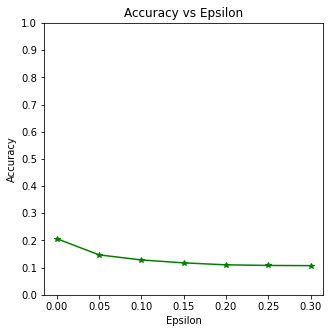

In [54]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", c='g')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

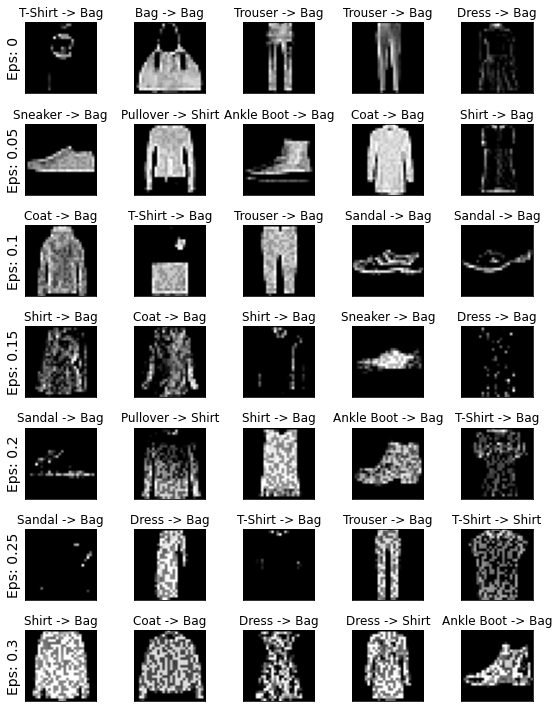

In [55]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(labels_map[orig], labels_map[adv]))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()